# Discovering Fair Principal Components

This notebook demonstrates the usage of Adversarial Principal Component Analysis (PCA), a method designed to remove confounding variables from the latent space representation. This technique is useful when we want to ensure that the extracted components are not influenced by confounders such as age, gender, or other demographic variables.

In this demonstration, we will:

1. Generate synthetic data with confounders.
2. Perform traditional PCA.
3. Apply Adversarial PCA to eliminate the confounding effect from the latent space.

We will visualize the latent space with each PCA model after being fit

## Load imports

We begin by loading the necessary libraries, including NumPy for data generation, `PCA` from _scikit-learn_ for traditional principal component analysis, and the custom implementation of adversarial PCA  `PPCAadversarial` from _bystro_.

In [1]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from scipy.stats import ortho_group


import matplotlib.pyplot as plt

from bystro.supervised_ppca.ppca_augmented import PPCAadversarial

## Generate synthetic data

We will now generate synthetic data to simulate a scenario with confounding variables. The data generation mechanism is as follows:

- **Latent Factors**: We simulate 3 latent factors that are responsible for generating the main data.
- **Confounders**: We introduce 4 confounders (e.g., age, demographic information), which will affect the observed data.
- **Noise**: Both the data and the confounders are perturbed by Gaussian noise to simulate real-world data variability.

The data is generated according to the following steps:

1. Generate latent factors from a multivariate normal distribution.
2. Combine the latent factors with an orthogonal weight matrix to create the noiseless data.
3. Generate confounders that are influenced by the latent factors.
4. Add noise to both the data and the confounders to simulate noisy observations.
5. Return the final dataset, including the observed features, confounder labels, and the true latent factors.
This generated dataset will be used for demonstrating how adversarial PCA can remove the influence of confounders.

In [2]:
def generate_data(sample_size=10000,
                  data_dim=80,
                  latent_dim=3,
                  confounder_dim=4,
                  noise_data=.5,
                  noise_confounder=.1,
                  seed=2021):
    rng = np.random.default_rng(seed)
    W_o = ortho_group.rvs(data_dim,random_state=seed)
    D_o = ortho_group.rvs(confounder_dim,random_state=seed+1)
    W = W_o[:,:latent_dim].T
    D = D_o[:,:latent_dim].T
    D[1:] = 0
    
    W[0] *= 2
    
    
    factors = rng.normal(size=(sample_size,latent_dim))
    
    X_nonoise = np.dot(factors,W)
    Y = np.dot(1*(factors>0),D) # Make this a binary label
    
    X_noise = rng.normal(size=(sample_size,data_dim))*noise_data
    Y_noise = rng.normal(size=(sample_size,confounder_dim))*noise_confounder
    X = X_nonoise + X_noise
    
    return X,Y,W,D,factors


## Visualizing Latent space

The next step is to visualize the latent space. We will plot the first two principal components and color the points by group (confounder label). This visualization will help us understand how the confounders influence the latent space representation.

In [3]:
def plot_pca_latent_space(S_adv, group_idx, 
                          xlabel='First Principal Component', 
                          ylabel='Second Principal Component', 
                          title='PCA Latent Space', 
                          fontsize_title=24, 
                          fontsize_labels=20, 
                          fontsize_legend=14, 
                          point_size=10,
                          legend_point_size=50):
    plt.figure(figsize=(8,6))
    
    # Scatter plot for two groups with regular point size
    scatter1 = plt.scatter(S_adv[group_idx==1,0], S_adv[group_idx==1,1], 
                           c='navy', s=point_size, label='Group 1', alpha=0.7)
    scatter2 = plt.scatter(S_adv[group_idx==0,0], S_adv[group_idx==0,1], 
                           c='gold', s=point_size, label='Group 2', alpha=0.7)
    
    # Labels and Title
    plt.xlabel(xlabel, fontsize=fontsize_labels)
    plt.ylabel(ylabel, fontsize=fontsize_labels)
    plt.title(title, fontsize=fontsize_title)
    
    # Creating custom legend with larger point size
    plt.legend([scatter1, scatter2], ['Group 1', 'Group 2'], 
               scatterpoints=1, loc='upper right', fontsize=fontsize_legend, 
               markerscale=legend_point_size/point_size)
    
    # Style adjustments: borders, bolder axes, removing top and right borders
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    
    plt.tight_layout()
    plt.show()

In [4]:
X,Y,W,D,factors = generate_data()
group_idx = 1.0*(factors[:,0] > 0)

## Fit standard principal component analysis

In [5]:
model_pca = PCA(3)
S_pca = model_pca.fit_transform(X)

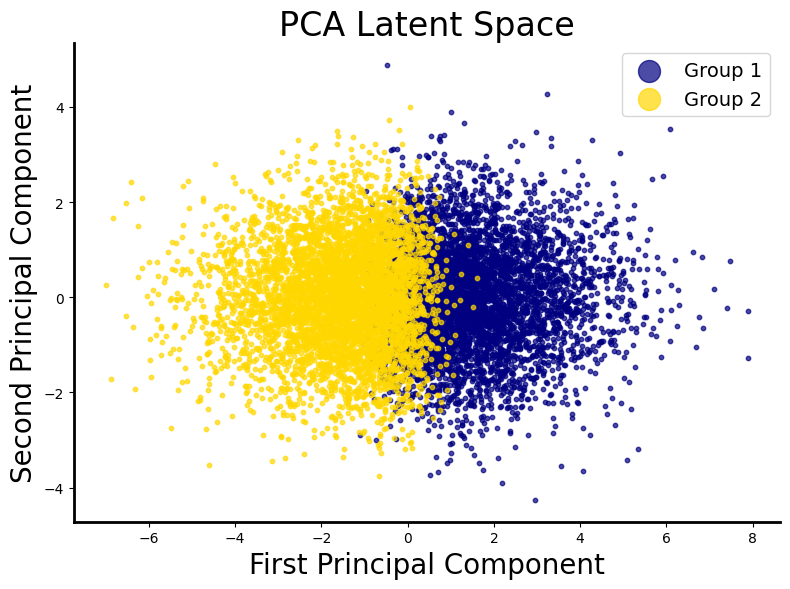

In [6]:
plot_pca_latent_space(S_pca,group_idx)

Note that there is a clear division between the two groups in the first component (which we have designed to contain all of the information relevant to the confounding variables). As a result, any version of PCA which focuses on reconstructing the variance will be highly predictive of the confounding variables.

## Fit adversarial principal component analysis

We now fit our custom analysis

In [7]:
model_adversarial = PPCAadversarial(2,mu=10000.0,regularization="QuadraticInverse")
model_adversarial.fit(X,Y)
S_adv = model_adversarial.transform(X)

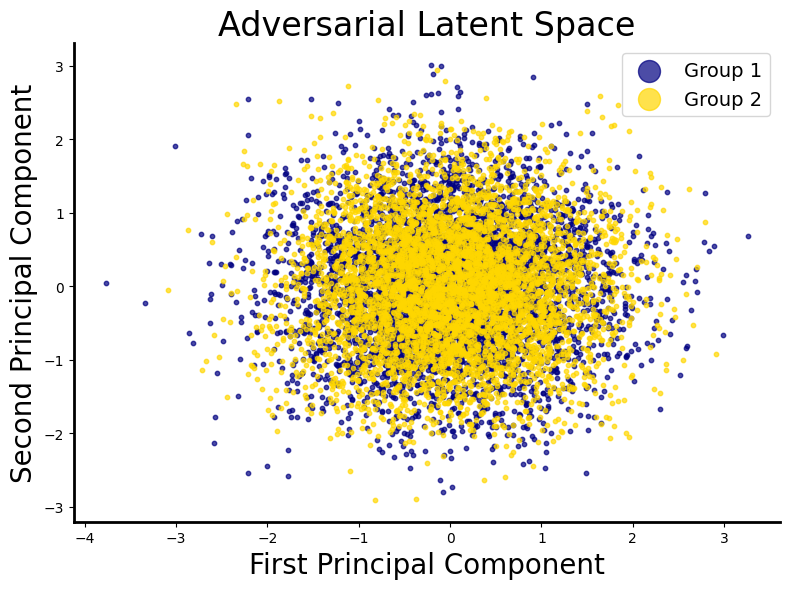

In [8]:
plot_pca_latent_space(S_adv,group_idx,title='Adversarial Latent Space')